In [1]:
import all_functions_tda as aftda
#import classifiers
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
# from ripser import ripser, plot_dgms

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import seaborn as sns
import pickle
from sklearn import datasets
import csv
import numpy as np
import datetime
import random

from ripser import ripser, plot_dgms

# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import scipy.interpolate as interp

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Loading original data, which has already been preprocessed in forms of persistence diagrams

In the main file with functions there are functions, used in the pipeline for creation of persistence diagrams (PDs). Those functions were previously applied to each dataset and rips filtrations were created, this code was run on separate server, as this task was computationally intense. Here we just load the pickles with olready created persistence diagrams. 

Each pd in the datasets <code>em_PD</code> and <code>rh_PD</code> contain both 0D and 1D homologies, while for our research we need to focus on 1D homologies, following all papers on the topic. We also tryed to extract 2D homologies, but there were none of them for most data, so we did not focus on them.

Additionally, we get rid of diagonal elements (which has died at the moment of the birth), as they are meaningless.

In [3]:
with open('elo_merchant/titles.csv', 'r') as f:
    reader = csv.reader(f)
    em_titles = list(reader)[0]
    
em_PDs = aftda.load_pkl('elo_merchant/rips_filtrations') 

rh_titles = aftda.load_pkl('redhat/titles')
rh_PDs = aftda.load_pkl('redhat/rips_filtrations') 

And following the paper by Lacombe, we need to discretize PDs: we encode them as histograms on the square, so we can represent them as $d \times d$ square matrices, which makes them more convenient to work with. The encoding process was as follows:
* We calculate the maximum (the most persistent) point among all PDs in given dataset
* We therefore create square matrix $\mathbf{a} \in \mathbb{R}^{d \times d}$, for which each element $a_{ij}$ corresponds to the number of points in original PD, located in cell at position $(i, \: j)$ on the grid
* We then associate to each histogram its mass, which corresponds to the number of off-diagonal points in the original PD, and this fact is extremely important feature of this approach

Also here we initialize the parameters for the algorithm, which are:
* $d$ — size of the grid for encoding
* $\gamma$ — smoothing parameter, used in algorithm
* $\lambda$ — learning rate for algorithm 2
* $p$ — order of norm used in computations

In [4]:
d = 100
gamma = 0.2
Lambda = 0.01
p = 2

# we create class, which processes PDs to the needed format automatically
em_pd = aftda.persistence_diagram(em_PDs, d, gamma, Lambda) 
rh_pd = aftda.persistence_diagram(rh_PDs, d, gamma, Lambda)

### Here we present some visualaization of our data

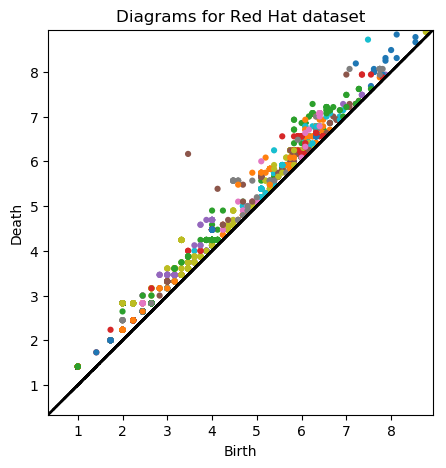

In [18]:
plt.figure(figsize = (5, 5), dpi = 100)
for pdg in rh_PDs[:500]:
    if len(pdg[1])!= 0:
        plot_dgms(pdg[1], legend = False)
plt.title('Diagrams for Red Hat dataset')
plt.show()

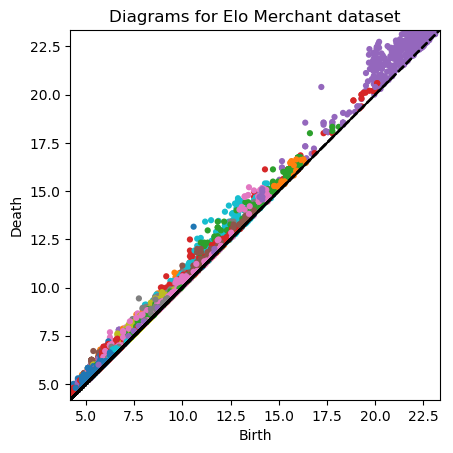

In [17]:
plt.figure(dpi = 100)
for pdg in em_PDs[:200]:
    if len(pdg[1])!= 0:
        plot_dgms(pdg[1], legend = False)
plt.title('Diagrams for Elo Merchant dataset')
plt.show()

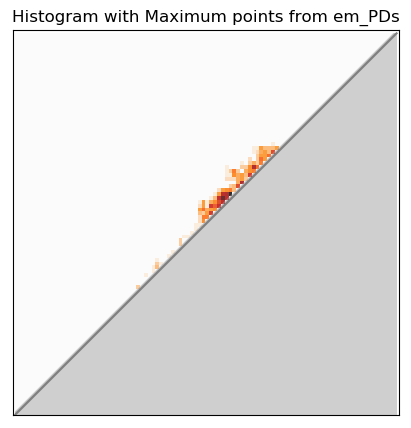

<Figure size 500x500 with 0 Axes>

In [19]:
aftda.plot_histogram(em_pd.histograms[44])
plt.title("Histogram with Maximum points from em_PDs")
plt.figure(figsize= (5,5))
plt.show()

# Make synthetic data

In addition to the original data, which is extremely big, we have created histograms with simple blobs, in order to test our approach. We create blobs of different size, in order to check how algoritm incorporates mass in the calculation of distance, and also we use blobs for clustering.

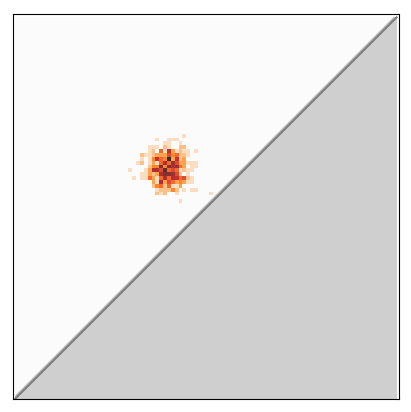

<Figure size 640x480 with 0 Axes>

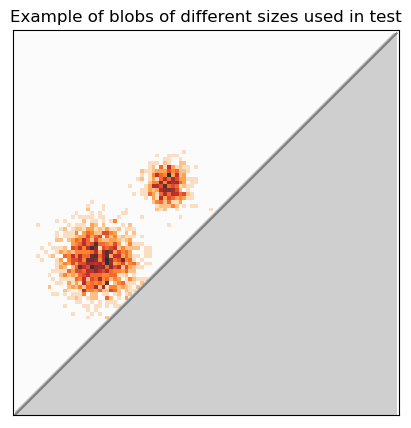

In [23]:
X, y = datasets.make_blobs(n_samples=500, n_features = 2, centers = [(40, 20)], cluster_std=3)
blob_2 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_2[i][j] +=1 
aftda.plot_histogram(blob_2)
plt.figure(2)
X, y = datasets.make_blobs(n_samples=1500, n_features = 2, centers = [(20, 2)], cluster_std=5)
blob_1 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_1[i][j] +=1 
aftda.plot_histogram(blob_1 + blob_2)
plt.title("Example of blobs of different sizes used in test")
plt.savefig('blobs.jpg')
plt.show()

# Finding optimal transport

## Plot kernels, which we used for calculation of optimal transport

As was described in the report, in order to approximate distances we use Sinkhorn map, defined as follows:
$$
    \mathbf{S} \: : \: (u, v) \to \left(\frac{a}{Kv},  \frac{b}{K^{\top}u}\right)
$$
Where kernel matrix $K$ is defined as follows:
\begin{equation}\label{cost_matrices}
    C = \begin{pmatrix}
    \hat{C} & \vec{\mathbf{c}}_{\Delta} \\
    \vec{\mathbf{c}}_{\Delta}^{\top} & 0
    \end{pmatrix}, \:\:\:
    K = \begin{pmatrix}
    \hat{K} := e^{- \frac{\hat{C}}{\gamma}} & \vec{\mathbf{k}}_{\Delta} := e^{- \frac{\vec{\mathbf{c}}_{\Delta}}{\gamma}}\\
    \vec{\mathbf{k}}_{\Delta}^{\top} & 1
    \end{pmatrix}
\end{equation}





$\mathbf{c}_{\Delta} = \left( \| (i, i') - \pi_{\Delta}((i, i')) \|^p_p\right)_{ii'}$ (here $\pi_{\Delta}$ is the projector on the diagonal)

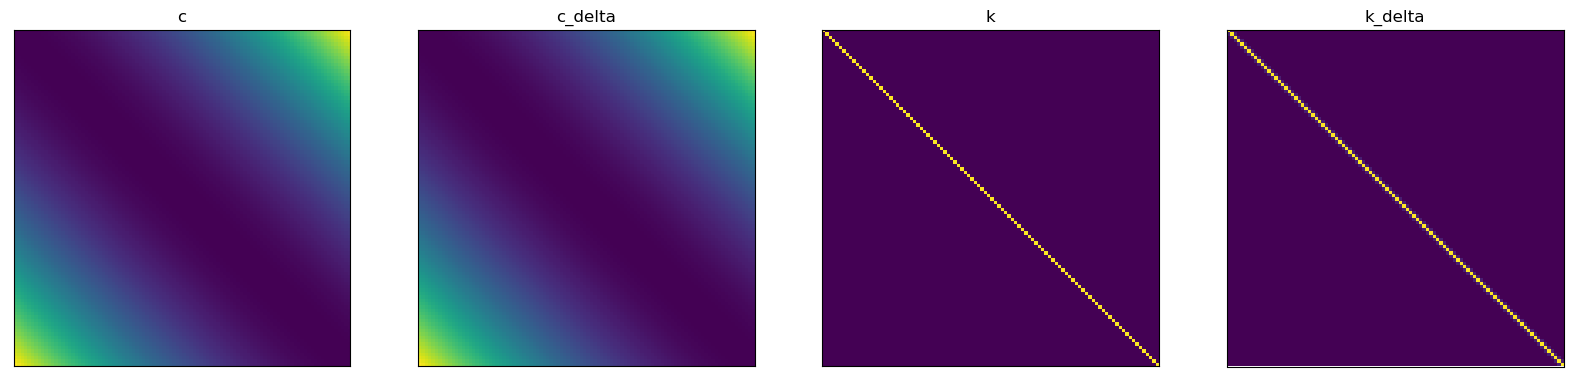

In [22]:
f, ax = plt.subplots(1, 4, figsize = (20,5))
plot_list = {    
   'c' : em_pd.c,
   'c_delta' : em_pd.c_delta,
   'k' : em_pd.k,
   'k_delta' : em_pd.k_delta
}
for i, key in enumerate(plot_list):
    ax[i].imshow(plot_list[key])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(key)
# plt.savefig('kernels.jpg')
plt.show()

## Compute Optimal Problem 

## Compute Optimal Problem 

Following the algorithm 1 from Lacombe, we have created the function which calculates optimal transport and included it in the class of persistence diagrams. Here we check whether it gives reasonable results for different and same diagrams from our dataset.

In [24]:
print('Optimal Transport Problem between 0 and 1 \t', 
      round(em_pd.optimal_transport(em_pd.histograms[0], em_pd.histograms[1])))
print('Optimal Transport Problem between 1 and 1 \t', 
      round(em_pd.optimal_transport(em_pd.histograms[1], em_pd.histograms[1])))

Optimal Transport Problem between 0 and 1 	 3.0
Optimal Transport Problem between 1 and 1 	 0.0


Text(0.5,1,'Second PD from elo dataset')

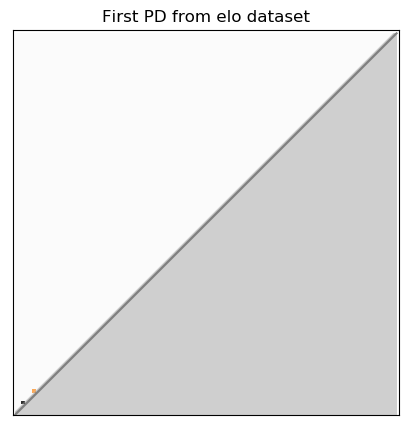

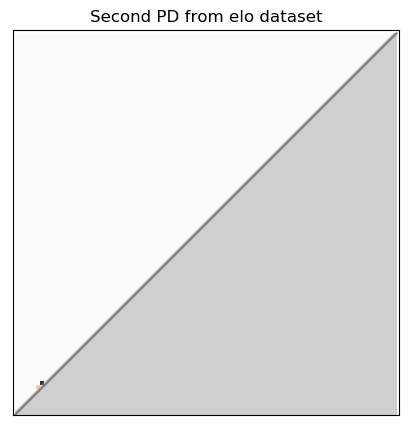

In [28]:
aftda.plot_histogram(em_pd.histograms[0])
plt.title('First PD from elo dataset')
aftda.plot_histogram(em_pd.histograms[1])
plt.title('Second PD from elo dataset')

However because our datasets are very sparse, we use artificial data to visualize and test the functions on them. For this purpose we created two blobs and moved one of them from another in order to see, how distance changes. 

Also we checked whether our algorithm indeed takes into consideration the mass of each histogram by creating and testing it on the blobs with different number of samples. The result you can see below.

In [19]:
X, y = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40, 20)], cluster_std=3)
blob_2 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_2[i][j] +=1 
# sns.heatmap(blob_2)
# plt.figure(2)
dist_list = []
dist_list_different = []
for k in range(0, 20):
    X, y = datasets.make_blobs(n_samples=350, n_features = 2, centers = [(40 + k, 20 + k)], cluster_std=3)
    blob_1 = np.ones((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    dist_list_different.append(pd.optimal_transport(blob_1, blob_2))
    
    
    X, y = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40 + k, 20 + k)], cluster_std=3)
    blob_1 = np.ones((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    dist_list.append(pd.optimal_transport(blob_1, blob_2))
#     plt.figure(i, figsize= (10,10), dpi = 100)
#     plt.imshow((blob_1 + blob_2).T,  cmap = plt.cm.gist_heat_r)
#     plt.ylim(0,100)
#     plt.savefig('blobs_' + str(k) + '.jpg',  )
# plt.figure(100, figsize= (10,10))
# x = [np.sqrt(2*k**2) for k in range(20)]
# plt.scatter(x , dist_list, c = 'r')
# plt.semilogy(x, dist_list, c = 'r', label = 'The same size of clusters')

# plt.scatter(x , dist_list_different, c = 'b')
# plt.semilogy(x, dist_list_different, c = 'b', label = 'Different size of clusters')

# plt.legend(log = 'lowerrig')
# plt.title('Distance between blobs')
# plt.ylabel('Sinkhorn Distance')
# plt.xlabel('Euclidian distance between centers')
# plt.savefig('distance.jpg')

# sns.heatmap(blob_1)

In [5]:
d=100
X, y = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40, 20)], cluster_std=3)
blob_2 = np.ones((d, d))
for x in X:
    i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
    if (i != j) and (i<j):
        blob_2[i][j] +=1 
# sns.heatmap(blob_2)
# plt.figure(2)
dist_list = []
dist_list_different = []
for k in range(0, 20):
    X, y = datasets.make_blobs(n_samples=350, n_features = 2, centers = [(40 + k, 20 + k)], cluster_std=3)
    blob_1 = np.ones((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    dist_list_different.append(pd.optimal_transport(blob_1, blob_2))
    
    
    X, y = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40 + k, 20 + k)], cluster_std=3)
    blob_1 = np.ones((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80 + 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    dist_list.append(pd.optimal_transport(blob_1, blob_2))

TypeError: not enough arguments: expected at least 9, got 2

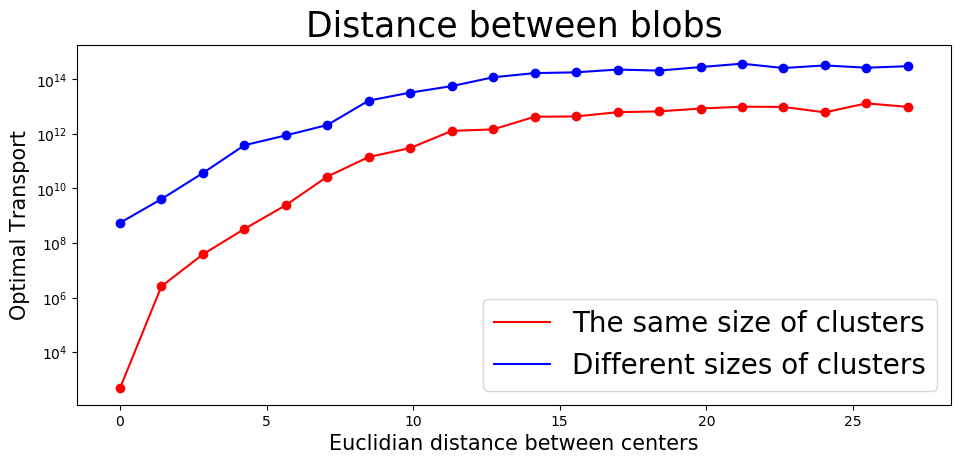

In [20]:
plt.figure(100, figsize= (10,5))
x = [np.sqrt(2*k**2) for k in range(20)]
plt.scatter(x , dist_list, c = 'r')
plt.semilogy(x, dist_list, c = 'r', label = 'The same size of clusters')

plt.scatter(x , dist_list_different, c = 'b')
plt.semilogy(x, dist_list_different, c = 'b', label = 'Different sizes of clusters')

plt.legend(loc = 'lower right', fontsize = 20)
plt.title('Distance between blobs', fontsize = 25)
plt.ylabel('Optimal Transport', fontsize = 15)
plt.xlabel('Euclidian distance between centers', fontsize = 15)
plt.savefig('distance.jpg')
plt.tight_layout(pad = 2)


Here we presented gif with the moving blobs, to illustrate the approach. This was done for blobs of the same size.

<img src="giphy_new.gif"/><img src="giphy-2.gif"/> 

In [14]:
import matplotlib
x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [0, 0.2, 0.3, 0.8]
colors = ["white","yellow","red", 'brown']

norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0., 'white'), (0.4, 'yellow'), (1.0, 'red')])

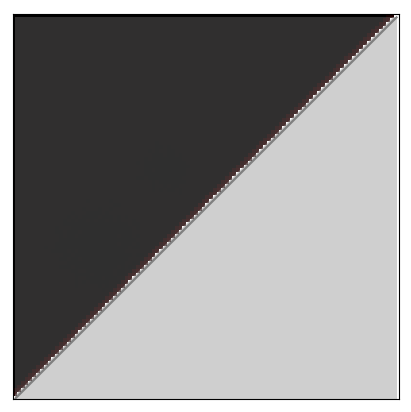

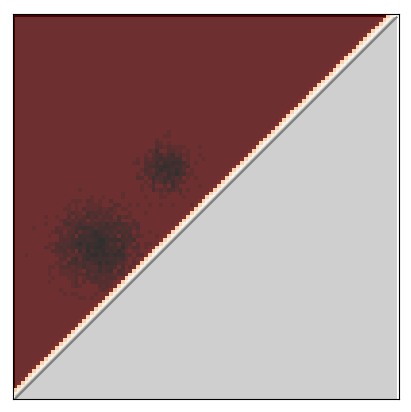

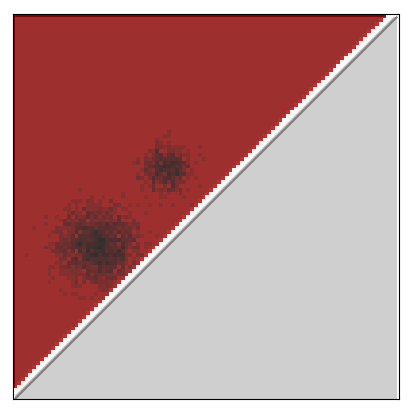

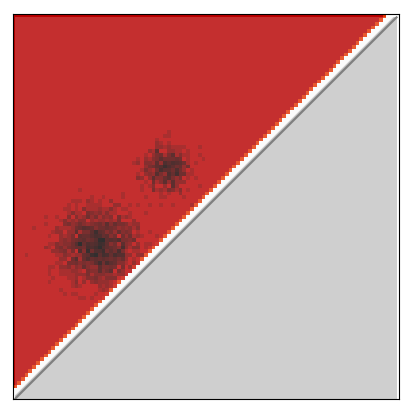

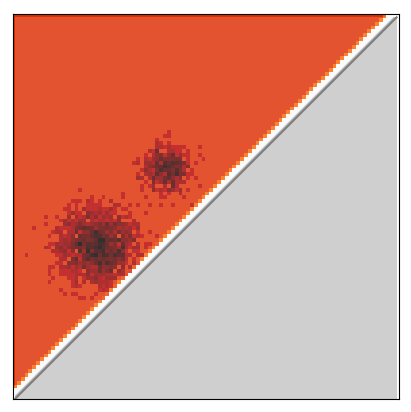

In [15]:
a_and_b = [blob_1,blob_2]
# a_and_b = [a,b]
# a_and_b = histograms[:3]
z, norm = pd.barycenter(a_and_b, 200, plots= 40)

Text(0.5, 0, 'Iterations')

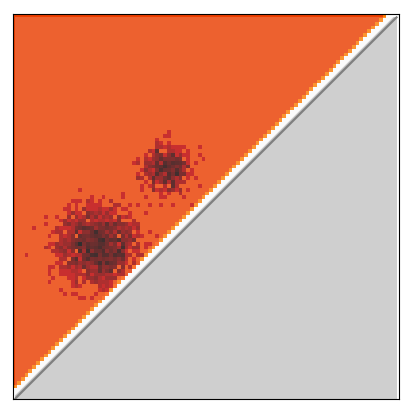

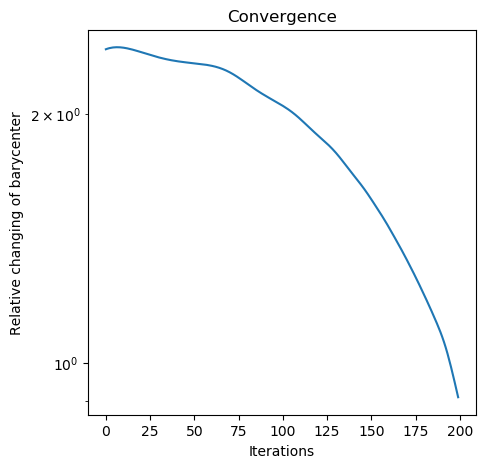

In [16]:
import seaborn as sns
aftda.plot_histogram(z)
plt.figure(2, figsize= (5,5))
plt.title("Convergence")
plt.semilogy(1000*np.array(norm))
plt.ylabel('Relative changing of barycenter')
plt.xlabel('Iterations')

In [17]:
a = np.zeros((d,d))
center_0 = 20
for i in range(100):
    ii = np.random.randint(low = -10, high = +10)
    jj = np.random.randint(low = -5, high = +5)
    a[center_0 + ii,2*center_0 + jj] += 1
    #a[i][i] = 1
b = np.zeros((d,d))
center_1 = 21
for i in range(100):
    ii = np.random.randint(low = -10, high = +10)
    jj = np.random.randint(low = -5, high = +5)
    b[center_1 + ii,2*center_1 + jj] += 1
    #b[i][i] = 1

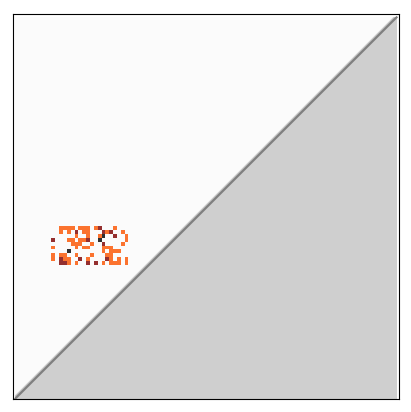

In [18]:
aftda.plot_histogram(a)

9751176462727.518


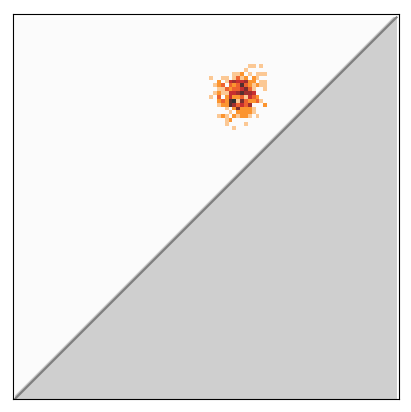

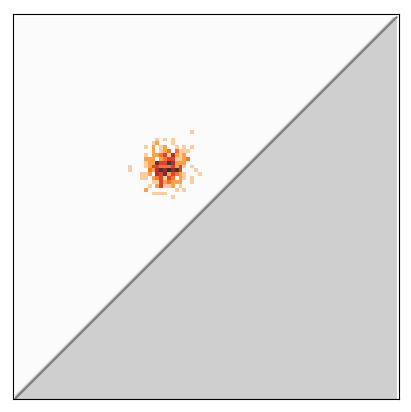

In [21]:
aftda.plot_histogram(blob_1)
aftda.plot_histogram(blob_2)
print(pd.optimal_transport(blob_1, blob_2))

In [22]:
blobs = []
data_points = []
for i in range(10):
    x = np.random.randint(0, 3)
    y = np.random.randint(0, 3)
    X, _ = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(40 + x - 1, 20 + y - 1)], cluster_std=3)
    blob_1 = np.zeros((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_1[i][j] +=1 
    
    data_points.append(X)
    x = np.random.randint(0, 3)
    y = np.random.randint(0, 3)
    X, _ = datasets.make_blobs(n_samples=300, n_features = 2, centers = [(65 + x - 1, 40 + y - 1)], cluster_std=3)
    blob_2 = np.zeros((d, d))
    for x in X:
        i, j =int(d*(x[1]+ 20)/(80+ 20 + 1.e-3)), int(d*(x[0]+ 20)/(80+ 20 + 1.e-3))
        if (i != j) and (i<j):
            blob_2[i][j] +=1 
    blobs.append(blob_1)
    blobs.append(blob_2)
    data_points.append(X)
    

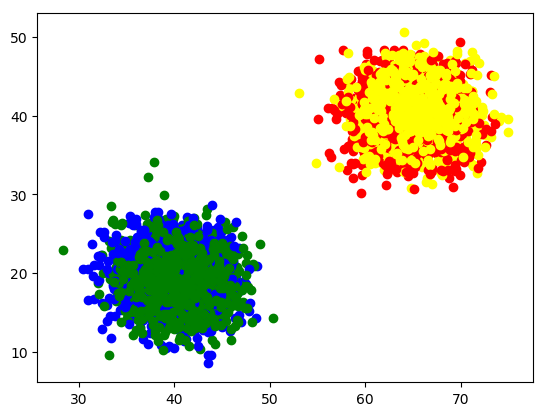

In [24]:
col = ['b','r','g','yellow']
for i in range(len(blobs)):
    plt.scatter(data_points[i][:,0], data_points[i][:,1], c =col[i%4])
    